In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as smf


# Proteomics Analysis

## Load dataset 

In [5]:
filename = 'proteinGroups.txt'

def select_cols(name):
    return 'LFQ' in name or name in ['Gene names', 'Reverse', 'Potential contaminant', 'Only identified by site', 'Species']

df = pd.read_table(filename, usecols=select_cols)
df.columns = [name.split(' ')[2] if 'LFQ' in name else name for name in df.columns]
df.head(30)

/home/nickdg/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (120,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Gene names,Shotgun_02-01_1,Shotgun_02-01_2,Shotgun_02-01_3,Shotgun_12-01_1,Shotgun_12-01_2,Shotgun_12-01_3,BoxCar_02-01_1,BoxCar_02-01_2,BoxCar_02-01_3,BoxCar_12-01_1,BoxCar_12-01_2,BoxCar_12-01_3,Species,Only identified by site,Reverse,Potential contaminant
0,SERPINB6,3643600000,2971500000,3188400000,3655800000,3605500000,4274800000,2003200000,2241800000,2328600000,2896200000,2667100000,3020800000,Homo sapiens,NaN,NaN,NaN
1,HDLBP,5321900000,4503700000,4356100000,5657400000,5466200000,5410700000,3061100000,2786500000,2728400000,3704300000,3703300000,3659800000,Homo sapiens,NaN,NaN,NaN
2,ELOF1,86756000,69719000,108880000,152760000,99195000,134370000,54177000,57759000,71338000,98382000,91200000,95218000,Homo sapiens,NaN,NaN,NaN
3,TCEB3,317040000,421780000,412000000,444980000,503490000,385790000,260160000,260520000,284200000,302950000,352410000,368110000,Homo sapiens,NaN,NaN,NaN
4,PPT2;hCG_1999928,36886000,24031000,28317000,41376000,36666000,42425000,22815000,20307000,21351000,28480000,28804000,24763000,Homo sapiens,NaN,NaN,NaN
5,BAG6;BAT3,1406300000,1420800000,1326200000,1788600000,1865200000,1665700000,1017100000,1034300000,952640000,1340100000,1270300000,1225900000,Homo sapiens,NaN,NaN,NaN
6,ATP11C,39446000,39843000,34252000,42252000,50732000,44785000,20673000,22884000,28361000,36241000,17339000,24050000,Homo sapiens,NaN,NaN,NaN
7,VGLL4,48154000,51180000,45666000,48010000,42978000,42451000,31057000,25713000,29435000,29287000,31469000,29191000,Homo sapiens,NaN,NaN,NaN
8,AMBRA1,0,0,0,21625000,0,14867000,0,5287300,6344100,0,8233500,6099700,Homo sapiens,NaN,NaN,NaN
9,EPPK1,729840000,654270000,804000000,947030000,867980000,826290000,449140000,576020000,469840000,693620000,659390000,614310000,Homo sapiens,NaN,NaN,NaN


In [24]:
df.columns

Index(['Gene names', 'Shotgun_02-01_1', 'Shotgun_02-01_2', 'Shotgun_02-01_3',
       'Shotgun_12-01_1', 'Shotgun_12-01_2', 'Shotgun_12-01_3',
       'BoxCar_02-01_1', 'BoxCar_02-01_2', 'BoxCar_02-01_3', 'BoxCar_12-01_1',
       'BoxCar_12-01_2', 'BoxCar_12-01_3', 'Species',
       'Only identified by site', 'Reverse', 'Potential contaminant'],
      dtype='object')

## Filter Data

Remove all rows that have a plus (+) sign in the "Reverse", "Potential Contaminant", and "Only identified..." columns

In [8]:
mask = (df['Reverse'] != '+') & (df['Potential contaminant'] != '+') & (df['Only identified by site'] != '+')

df_f = df[mask]

"Kept {} lines out of {} total: {:.2%}".format(len(df_f), len(df), len(df_f)/len(df))

'Kept 6644 lines out of 6882 total: 96.54%'

## Tidy Data: Change the DataFrame into a Long Format

In [9]:
dfl = pd.melt(df_f, id_vars=['Gene names', 'Species'], value_vars=[col for col in df_f.columns if '_' in col], value_name='ProteinAbundance', var_name='Group')
dfl.head()

,Gene names,Species,Group,ProteinAbundance
0,SERPINB6,Homo sapiens,Shotgun_02-01_1,3643600000
1,HDLBP,Homo sapiens,Shotgun_02-01_1,5321900000
2,ELOF1,Homo sapiens,Shotgun_02-01_1,86756000
3,TCEB3,Homo sapiens,Shotgun_02-01_1,317040000
4,PPT2;hCG_1999928,Homo sapiens,Shotgun_02-01_1,36886000


## Transform Data: Calculate the log2 of Protein Count
But first, set all protein counts of less than 10 to NaN (np.nan).

In [10]:
dfl.loc[dfl['ProteinAbundance'] < 10, 'ProteinAbundance'] = np.nan

dfl['LogProteinAbundance'] = np.log2(dfl['ProteinAbundance'])
dfl.head()

,Gene names,Species,Group,ProteinAbundance,LogProteinAbundance
0,SERPINB6,Homo sapiens,Shotgun_02-01_1,3.643600e+09,31.762717
1,HDLBP,Homo sapiens,Shotgun_02-01_1,5.321900e+09,32.309294
2,ELOF1,Homo sapiens,Shotgun_02-01_1,8.675600e+07,26.370460
3,TCEB3,Homo sapiens,Shotgun_02-01_1,3.170400e+08,28.240090
4,PPT2;hCG_1999928,Homo sapiens,Shotgun_02-01_1,3.688600e+07,25.136570


Visualize the distribution of the log protein abundance

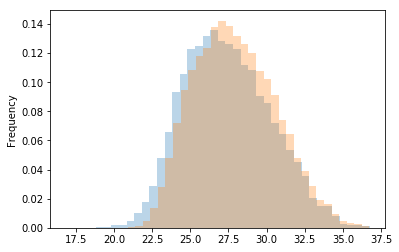

In [16]:
dfl.groupby('Species')['LogProteinAbundance'].plot.hist(alpha=.3, density=True, bins=40);

## Make "Method", "Sample", and "Replicate" Columns for Each Observation
 
  - **Method**: Shotgun, BoxCar
  - **Sample**: '02-01', '12-01'
  - **Replicate**: 1, 2, 3

In [21]:
groups = pd.DataFrame(dfl.Group.str.split('_').tolist(), columns=['Method', 'Sample', 'Replicate'])
groups.head()

,Method,Sample,Replicate
0,Shotgun,02-01,1
1,Shotgun,02-01,1
2,Shotgun,02-01,1
3,Shotgun,02-01,1
4,Shotgun,02-01,1


In [23]:
df_tidy = pd.concat([groups, dfl], axis=1)
del df_tidy['Group']
df_tidy.head()

,Method,Sample,Replicate,Gene names,Species,ProteinAbundance,LogProteinAbundance
0,Shotgun,02-01,1,SERPINB6,Homo sapiens,3.643600e+09,31.762717
1,Shotgun,02-01,1,HDLBP,Homo sapiens,5.321900e+09,32.309294
2,Shotgun,02-01,1,ELOF1,Homo sapiens,8.675600e+07,26.370460
3,Shotgun,02-01,1,TCEB3,Homo sapiens,3.170400e+08,28.240090
4,Shotgun,02-01,1,PPT2;hCG_1999928,Homo sapiens,3.688600e+07,25.136570


## Visualize Data: How do the Abundances Differ across conditions?

/home/nickdg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


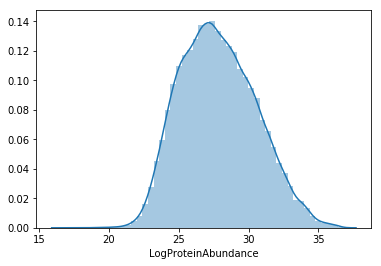

In [23]:
sns.distplot(df_tidy['LogProteinAbundance'].dropna())

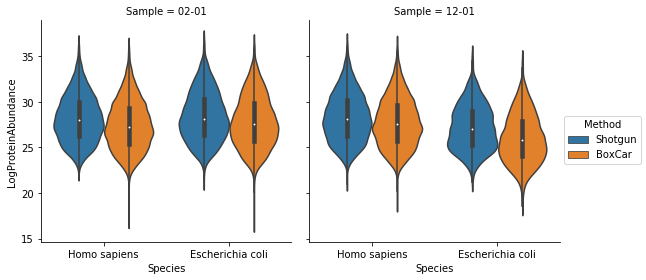

In [24]:
g = sns.factorplot(data=df_tidy, x='Species', y='LogProteinAbundance', hue='Method', col='Sample', kind='violin')

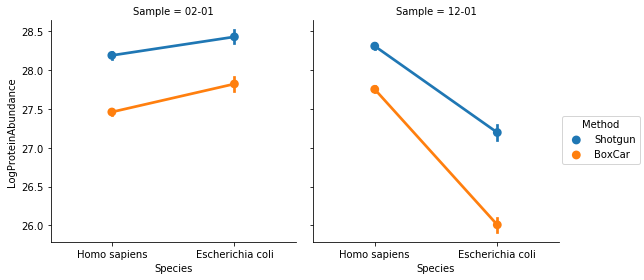

In [25]:
g = sns.factorplot(data=df_tidy, x='Species', y='LogProteinAbundance', hue='Method', col='Sample', kind='point', estimator=np.mean)

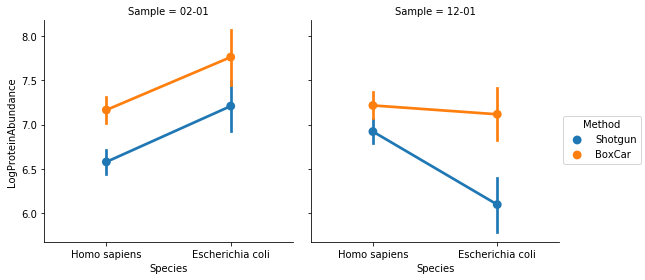

In [26]:
g = sns.factorplot(data=df_tidy, x='Species', y='LogProteinAbundance', hue='Method', col='Sample', kind='point', estimator=np.var)

## Ratio Analysis

What is the relationship between the 02-01 and 12-01 samples?

In [26]:
df_samples = pd.pivot_table(df_tidy, values='LogProteinAbundance', index=['Gene names', 'Species', 'Method'],
                columns=['Sample'], aggfunc=np.median).reset_index()
df_samples.head()

Sample,Gene names,Species,Method,02-01,12-01
0,AAAS,Homo sapiens,BoxCar,28.090582,28.339431
1,AAAS,Homo sapiens,Shotgun,28.521632,28.760467
2,AACS,Homo sapiens,BoxCar,25.652887,25.772233
3,AACS,Homo sapiens,Shotgun,26.873496,26.915246
4,AAK1,Homo sapiens,BoxCar,22.757069,23.247048


Make a scatter plot of log protein abundances, with 02-01 on the X axis and 12-01 on the y axis

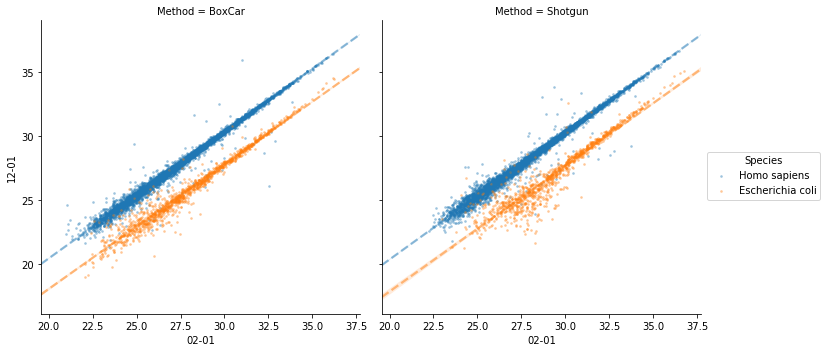

In [27]:
sns.lmplot(data=df_samples, x='02-01', y='12-01', hue='Species', col='Method', scatter_kws=dict(s=3, alpha=.3), line_kws=dict(linestyle='dashed', alpha=.5))

Calculate Ratio

In [28]:
df_ratio = df_samples['12-01'] - df_samples['02-01']
df_ratio.name = 'Protein Abundance Ratio'
df_ratio = df_ratio.reset_index()
df_ratio.head()

,index,Protein Abundance Ratio
0,0,0.248849
1,1,0.238835
2,2,0.119347
3,3,0.041750
4,4,0.489979


/home/nickdg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/nickdg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/nickdg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/nickdg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


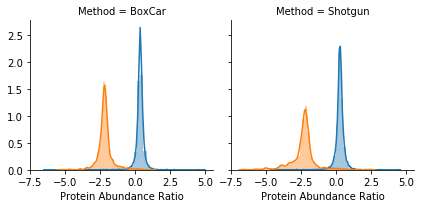

In [38]:
g = sns.FacetGrid(data=df_ratio, hue='Species', col='Method')
g.map(sns.distplot, 'Protein Abundance Ratio')

In [52]:
import statsmodels.api as smf

df_ratio['RR'] = df_ratio['Protein Abundance Ratio']

model = smf.formula.glm(data=df_ratio.dropna(), formula='RR ~ Method * Species').fit()
print(model.summary2())

                             Results: Generalized linear model
Model:                        GLM                      AIC:                    15081.2087  
Link Function:                identity                 BIC:                    -114148.8413
Dependent Variable:           RR                       Log-Likelihood:         -7536.6     
Date:                         2018-08-15 14:21         LL-Null:                -37708.     
No. Observations:             12377                    Deviance:               2449.3      
Df Model:                     3                        Pearson chi2:           2.45e+03    
Df Residuals:                 12373                    Scale:                  0.19796     
Method:                       IRLS                                                         
-------------------------------------------------------------------------------------------
                                           Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-----------------